In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors # LogNorm
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, MFDataset
import pandas as pd
from scipy import spatial # KDTree search
from datetime import datetime
from datetime import timedelta
import glob # read BYU giant iceberg files
import os
import gc
from IPython.display import clear_output # progressbar

In [43]:
cd ./ForcingDataERA5ECCO2/

/Users/trackow/Documents/science-icebergs-lgm/ForcingDataERA5ECCO2


In [45]:
ls

AVGMON_ECCO2_salt_salinity_[psu].nc*
AVGMON_ECCO2_siarea_seaice_fractional_ice-covered_area_[m^2_m^2].nc*
AVGMON_ECCO2_ssh_sea_surface_height_[m].nc*
AVGMON_ECCO2_theta_potential_temperature_[deg_c].nc*
AVGMON_ECCO2_uvel_zonal_velocity_[m_s].nc*
AVGMON_ECCO2_vvel_meridional_velocity_[m_s].nc*
AVGMON_ERA5_Mavg_1997_2019_so_windcomponents.nc*
AVGMON_SIuice_seaice_x-dir._ice_velocity_[m_s].nc*
AVGMON_SIvice_seaice_y-dir._ice_velocity_[m_s].nc*
\1997\height.csv
\1997\lats.csv
\1997\lenght.csv
\1997\lons.csv
\1997\melt.csv


In [46]:
EXP='PD' # present-day run with ERA5 and ECCO forcing
gc.collect()

578883

### Plot Field

In [47]:
def plot_field(plotfield, cbar_label='field', vmin=-2., vmax=2.):
    
    m = Basemap(projection='spstere',boundinglat=-34,lon_0=180,resolution='l')
    #m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
    m.drawcoastlines()

    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))

    # plot
    lon_map,lat_map=m(XX[:,:],YY[:,:])
    im=m.contourf(lon_map,lat_map, plotfield, vmin=vmin, vmax=vmax)

    # colorbar
    cbar=plt.colorbar()
    cbar.set_label(cbar_label)

    plt.show()

### Open and look at the forcing data

In [48]:
# load interpolated COSMO data (1x1 degree)
def loaddata(filen, variable, returncoords=False, threeD=False):
    
    # let's construct the file name
    pathtofile = "./"
    
    # the file to be loaded
    filename = pathtofile + filen
    
    print("loading " + filename + " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)
    
    print('Variables: ', fl.variables.keys())
    
    if 'longitude' in fl.variables.keys():
        lon = 'longitude'
        lat = 'latitude'
            
    if 'lon' in fl.variables.keys():
        lon = 'lon'
        lat = 'lat'
        
    
    # lon lat on grid
    lon_start = np.asarray(fl.variables[lon])
    lat_start = np.asarray(fl.variables[lat])
    inputfield = np.asarray(fl.variables[variable])

    if threeD==True:
        depth=np.asarray(fl.variables['lev'])
    
    print('Inputfield shape: ', inputfield.shape)
    
    fl.close()
    gc.collect()
        
    if returncoords==True and threeD==False:
        XX, YY = np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY
    elif returncoords==True and threeD==True:
        XX, YY = np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY, depth
    else:
        return inputfield

In [49]:
def compute_gradient(SSH, XX, YY):
    
    rad=np.pi/180.0 # radiant <-> degree
    m, l, c = SSH.shape
    
    # add column to the left and right
    addcol=np.concatenate([np.expand_dims(SSH[:,:,-1],axis=2),SSH,np.expand_dims(SSH[:,:,0], axis=2)],axis=2)
    addcXX=np.concatenate([np.expand_dims(np.ones_like(XX[:,-1])*-1.,axis=1),XX,np.expand_dims(np.ones_like(XX[:,0])*360., axis=1)],axis=1)
    addcYY=np.concatenate([np.expand_dims(YY[:,-1],axis=1),YY,np.expand_dims(YY[:,0], axis=1)],axis=1)
    
    # SSH: (12, 180, 362) # already has columns added left and right
    lats=YY[:,0]
    ddx=np.zeros_like(SSH)
    ddy=np.zeros_like(SSH)
    
    # 1 ... 360 (0 and 361 were added)
    for column in np.arange(1,c+1): #360
        #print column
        ddx[:,:,column-1]=(addcol[:,:,column+1]-addcol[:,:,column-1])/(2.*111000.)
        
    for row in np.arange(1,l-1): #180-1
        #print row
        ddy[:,row,:]=(SSH[:,row+1,:]-SSH[:,row-1,:])/(2.*111000.*np.cos(YY[row,0]*rad))
        
    return ddx, ddy

## The iceberg drift (and decay) code

- Drag coefficients are set to the **default** as in [Rackow et al. (2017)](https://doi.org/10.1002/2016JC012513)
- **Initial iceberg positions and sizes** from [Wesche and Dierking (2015)](https://doi.org/10.1016/j.rse.2014.10.025), [download-link](https://doi.pangaea.de/10.1594/PANGAEA.843280) for the data stored in _Wesche-Dierking2015.csv_ (this repository)

In [78]:
class Buoys:
    
    gc.collect()
    
    global rad, r_earth, g, omega, Co, Ca, Cdo_skin, Cda_skin, semiimplicit_coeff, rho_h2o, \
    rho_icb, rho_air, smallestvol_icb, coriolis_slope_only, l_weeksmellor
    
    rad=np.pi/180.0 # radiant <-> degree
    r_earth=6.3675*10**6 # radius of Earth in [m]
    g=9.81
    omega=7.2921e-5 # make latitude dependent later
    
    # if using iceberg dynamics:
    Co=0.85 # Lichey and Hellmer values
    Ca=0.4 # 0.4 # Lichey and Hellmer values
    Cdo_skin=5.0e-3 # Cd_oce_ice in FESOM is 5.0e-3
    Cda_skin=2.5e-3
    rho_icb=850.0 # Silva et al. 2006
    rho_h2o=1027.5
    rho_air=1.293
    smallestvol_icb=10.*10.*10. # 1000. #10000. # [m**3]
    semiimplicit_coeff=1.0 # fully implicit # 0.5 default
    coriolis_slope_only=False
    l_weeksmellor=True
    
    def __init__(self, lon_start, lat_start, earliest_date_of_buoy, start_advect_date, L, W, H):
        self.oldlon = lon_start*rad
        self.oldlat = lat_start*rad
        self.lon = lon_start*rad
        self.lat = lat_start*rad
        self.initlon = lon_start*rad
        self.initlat = lat_start*rad
        self.old_u = np.zeros(lon_start.shape)
        self.old_v = np.zeros(lon_start.shape)
        self.date = datetime.strptime(earliest_date_of_buoy, "%Y-%m-%d %H:%M:%S")
        self.startdates = start_advect_date
        self.L=L
        self.W=W
        self.H=H
        self.mass=L*W*H*rho_icb
        self.D = (rho_icb/rho_h2o)*H
        self.Ao = self.D * L
        self.Aa = (H - self.D) * L
        self.Ad = L * W
        self.volloss= 0. # m^3/second
       
    def getdate(self):
        return self.date.strftime("%Y-%m-%d %H:%M:%S")
    
    def getmonth_forcing(self):
        return np.int(self.date.month)-1
        
    def trajectory(self, new_u, new_v, delta_t):
        
        #print("Update positions. Integrate for " + str(delta_t/3600.) + " hours.")
        
        #save old position in case the drifter leaves the domain
        self.oldlon = self.lon # radiant
        self.oldlat = self.lat # radiant
        
        #displacement vectors
        deltax1 = self.old_u * delta_t
        deltay1 = self.old_v * delta_t
        deltax2 = new_u * delta_t
        deltay2 = new_v * delta_t
        
        #Heun method (2nd order)
        self.lon = self.lon + (0.5*(deltax1 + deltax2) / (r_earth*np.cos(self.lat.values)))
        self.lat = self.lat + (0.5*(deltay1 + deltay2) /  r_earth )
        
        # keep degree in range 0..360 and -90..90
        lon_deg=self.lon/rad % 360
        lat_deg=np.clip(self.lat/rad, -90., 90.)
        self.lon = lon_deg*rad
        self.lat = lat_deg*rad
        
        #update velocity here (old value was needed for heun method)
        self.old_u=new_u
        self.old_v=new_v
        
        # set positions to NaN before the buoy is supposed to move
        idx=getindices_beforestart(self.getdate(), self.startdates)
        lon_deg[idx] = np.nan
        lat_deg[idx] = np.nan
        self.lon[idx] = self.initlon[idx]
        self.lat[idx] = self.initlat[idx]
        self.old_u[idx]=0.
        self.old_v[idx]=0.
        
        # update time stamp
        self.date = self.date + timedelta(seconds=delta_t)
        
        # iceberg already melted?
        lon_deg[self.mass==0.]= 0.
        lat_deg[self.mass==0.]= 0.

        return lon_deg, lat_deg
    
    def momentum_balance(self, au_ib, av_ib, dt_ib, uo_ib, vo_ib, uo_skin_ib, vo_skin_ib):
        
        new_u_ib = self.old_u + au_ib * dt_ib
        new_v_ib = self.old_v + av_ib * dt_ib
        
        # for semiimplicit version, a matrix multiplication is to be performed
        # (semiimpl. coriolis term and implicit water drag)
 
        abs_omib = np.sqrt( (uo_ib - self.old_u)**2 + (vo_ib - self.old_v)**2 )
        abs_omib_skin = np.sqrt( (uo_skin_ib - self.old_u)**2 + (vo_skin_ib - self.old_v)**2 )
        ocean_drag = (0.5 * Co * rho_h2o * self.Ao * abs_omib + rho_h2o * Cdo_skin * self.Ad * abs_omib_skin)/self.mass
   
        # update fcoriolis
        fcoriolis=2.*omega*np.sin(self.lat.values)
        
        # for tests with Coriolis and surface slope only
        if coriolis_slope_only==True:
            ocean_drag=np.zeros_like(abs_omib_skin)
        
        #FORTRAN:
        #SI_matrix(1,1) = 1. + dt_ib*ocean_drag
        #SI_matrix(1,2) = dt_ib*fcoriolis*semiimplicit_coeff
        #SI_matrix(2,1) =-SI_matrix(1,2)
        #SI_matrix(2,2) = SI_matrix(1,1)
        #SI_matrix = (1./( SI_matrix(2,2)**2 + SI_matrix(1,2)**2 )) * SI_matrix
        SI_matrix=np.array([[1. + dt_ib*ocean_drag, dt_ib*fcoriolis*semiimplicit_coeff*np.ones_like(ocean_drag)], \
                            [-dt_ib*fcoriolis*semiimplicit_coeff*np.ones_like(ocean_drag), 1. + dt_ib*ocean_drag]])
        
        SI_matrix = (1./( SI_matrix[1,1]**2 + SI_matrix[0,1]**2 )) * SI_matrix
        
        # new velocity after matrix multiplication
        # (2, 2, #bergs) x (2, #bergs)
        uv_temp=np.array([new_u_ib, new_v_ib])
        new_u_ib=sum(SI_matrix[0, 0:2, :] * uv_temp[0:2 , :])
        new_v_ib=sum(SI_matrix[1, 0:2, :] * uv_temp[0:2 , :])
        
        # rewrite like this..?
        #SI_matrix = np.einsum('ijn->nij', SI_matrix)
        #new_UV = np.dot(SI_matrix,[new_u_ib, new_v_ib])
        
        # might be melted already
        new_u_ib[self.mass==0.]=0.
        new_v_ib[self.mass==0.]=0.
        
        return new_u_ib, new_v_ib
    
    def compute_areas(self):
        
        # area of iceberg exposed to ocean, atm, (seaice), horizontal area
        self.Ao = self.D * self.L
        self.Aa = (self.H - self.D) * self.L
        # Ai = hi_ib * self.L
        self.Ad = self.L * self.W
    
    def acceleration(self, ua_ib, va_ib, uo_ib, vo_ib, uo_skin_ib, vo_skin_ib, detadx, detady):
        
        #l_wave=True
        l_wave=False
    
        # estimate wave height at the icebergs location (Bigg et al., 1997),
        # so wave_amplitude = 0.5 * wave_height = 0.5 * const. * abs(atm velo)**2
        vel_atm = np.sqrt(ua_ib**2 + va_ib**2)
        wave_amplitude = 0.5 * 0.02025 * vel_atm**2

        # assume that waves have same direction as the winds
        direction_u = ua_ib / vel_atm
        direction_v = va_ib / vel_atm

        # absolute values of relative velocities 
        abs_omib = np.sqrt( (uo_ib - self.old_u)**2 + (vo_ib - self.old_v)**2 )
        abs_amib = np.sqrt( (ua_ib - self.old_u)**2 + (va_ib - self.old_u)**2 )
        #abs_imib = sqrt( (ui_ib - u_ib)**2 + (vi_ib - v_ib)**2 )  
        abs_omib_skin = np.sqrt( (uo_skin_ib - self.old_u)**2 + (vo_skin_ib - self.old_v)**2 )

        # u-components        
        ocean_drag_u     = (0.5 * Co * rho_h2o * self.Ao * abs_omib * uo_ib)/self.mass #calculate part of it implicitly
        ocean_skin_u     = (rho_h2o * Cdo_skin * self.Ad * abs_omib_skin * uo_skin_ib)/self.mass # calculate part of it implicitly      
        air_drag_u       = (0.5 * Ca * rho_air * self.Aa * abs_amib * (ua_ib - self.old_u))/self.mass
        air_skin_u       = (rho_air * Cda_skin * self.Ad * abs_amib * (ua_ib - self.old_u))/self.mass 
        #ice_drag_u       = (0.5 * Ci * rho_ice * Ai * abs_imib * (ui_ib - u_ib))/mass_ib

        if l_wave==True:
            wave_radiation_u = 1./4. * rho_h2o * g * self.L * wave_amplitude**2 * direction_u /self.mass
        else:
            wave_radiation_u = 0.0

        # Fortran code used gradient smoothing for surface slope term;
        # only needed for higher resolutions.
        # call mean_gradient(iceberg_elem, lon_rad, lat_rad, nablaeta)
        # no surface slope due to tides here

        surface_slope_u = -g * detadx #* sum( ssh(elem2D_nodes(:,iceberg_elem)) * bafux_2D(:,iceberg_elem) ) # -g* nabla ssh


        # v-components     
        ocean_drag_v     = (0.5 * Co * rho_h2o * self.Ao * abs_omib * vo_ib)/self.mass # calculate part of it implicitly
        ocean_skin_v     = (rho_h2o * Cdo_skin * self.Ad * abs_omib_skin * vo_skin_ib)/self.mass #calculate part of it implicitly
        air_drag_v       = (0.5 * Ca * rho_air * self.Aa * abs_amib * (va_ib - self.old_v))/self.mass
        air_skin_v       = (rho_air * Cda_skin * self.Ad * abs_amib * (va_ib - self.old_v))/self.mass 
        #ice_drag_v       = (0.5 * Ci * rho_ice * Ai * abs_imib * (vi_ib - v_ib))/mass_ib

        if l_wave==True:
            wave_radiation_v = 1./4. * rho_h2o * g * self.L * wave_amplitude**2 * direction_v /self.mass
        else:
            wave_radiation_v = 0.0

        # no additional surface slope due to tides

        surface_slope_v = -g * detady #* sum( ssh(elem2D_nodes(:,iceberg_elem)) * bafuy_2D(:,iceberg_elem) )

        #USE (SEMI-)IMPLICIT SCHEME for coriolis term
        
        # update fcoriolis
        fcoriolis=2.*omega*np.sin(self.lat.values)

        au_ib = ocean_drag_u \
        + ocean_skin_u    \
        + air_drag_u       \
        + air_skin_u        \
        + wave_radiation_u   \
        + surface_slope_u    \
        + (1.-semiimplicit_coeff)*fcoriolis*self.old_v 

        av_ib = ocean_drag_v \
        + ocean_skin_v    \
        + air_drag_v       \
        + air_skin_v        \
        + wave_radiation_v   \
        + surface_slope_v    \
        - (1.-semiimplicit_coeff)*fcoriolis*self.old_u
        
        
        # TEST FOR CORIOLIS and SLOPE only:
        if coriolis_slope_only==True:
            au_ib = surface_slope_u + (1.-semiimplicit_coeff)*fcoriolis*self.old_v 
            av_ib = surface_slope_v - (1.-semiimplicit_coeff)*fcoriolis*self.old_u
            
            
        # might be melted already    
        au_ib[self.mass==0.] = 0.   
        av_ib[self.mass==0.] = 0.
        
        return au_ib, av_ib
    
    def iceberg_meltrates(self, delta_t, sst_ib, conci_ib, uo_ib, vo_ib, ua_ib, va_ib, heuristic=False):
        
        if heuristic==True:
            
            # rate in m/s
            rate_per_month=1.7/100. # area (L*L) red. rate in m/month (Barbat et al., 2020)
            rate_per_second=np.sqrt(rate_per_month/(86400.*30.)) # L red. rate
            
            self.L = self.L - delta_t*rate_per_second
            self.W = self.W - delta_t*rate_per_second
            self.mass = self.H * self.L * self.W * rho_icb
            
        else:
            
            # calculates the empirical melt rates of the iceberg as in 
            # Martin: 'Parameterizing the fresh-water flux from land ice to ocean
            # with interactive icebergs in a coupled climate model'(2010)
            # and Hellmer et al. (1997).
            # (notice that the melt rates are in terms of m/s though, not in m/day)
            
            # bottom melt rate: M_b   [m/s]
            # lateral melt rate: M_v   [m/s]
            # wave erosion: M_e   [m/s]
            # lateral (basal) melt rate: M_bv [m/s]

            # NO (3eq formulation for basal melting yet;
            # use 3D information for T,S and velocities
            # instead of SSTs; M_v depends on 'thermal driving')
  
            # bottom melt (basal turbulent melting rate)
            M_b = np.zeros_like(self.L)
            M_b[self.L>0.] = 0.58 * np.sqrt( (self.old_u[self.L>0.] - uo_ib[self.L>0.])**2 + (self.old_v[self.L>0.] - vo_ib[self.L>0.])**2 )**0.8 * (sst_ib[self.L>0.] + 4.0) / self.L[self.L>0.]**0.2
            M_b = M_b/86400. # conversion of m/day to m/s

            #3-eq. formulation for bottom melting [m/s]    
            #v_ibmino  = sqrt( (u_ib - uo_keel_ib)**2 + (v_ib - vo_keel_ib)**2 )
            #call iceberg_heat_water_fluxes_3eq(ib, M_b, T_keel_ib,S_keel_ib,v_ibmino, depth_ib, tf)

            #3-eq. formulation for lateral 'basal' melting [m/s]
            #v_ibmino  = sqrt( (u_ib - uo_ib)**2 + (v_ib - vo_ib)**2 ) ! depth-average rel. velocity
            #call iceberg_heat_water_fluxes_3eq(ib, M_bv, T_ave_ib,S_ave_ib,v_ibmino, depth_ib/2.0, tf)
            M_bv=M_b

            #'thermal driving', defined as the elevation of ambient water 
            #temperature above freezing point' (Neshyba and Josberger, 1979).
            
            T_ave_ib=sst_ib # use sst for the moment
            tf=-2. # use constant value at the moment
            
            # thermal driving temp
            T_d = (T_ave_ib - tf) * np.ones_like(self.L)
            T_d[T_d < 0.]=0. 
            
            #!write(*,*) 'thermal driving:',T_d,'; Tf:',tf,'T_ave:',T_ave_ib

            #lateral melt (buoyant convection)
            #M_v = 0.00762 * sst_ib + 0.00129 * sst_ib**2
            #M_v = M_v/86400.
            #M_v is a function of the 'thermal driving', NOT just sst! Cf. Neshyba and Josberger (1979)
            M_v = 0.00762 * T_d + 0.00129 * T_d**2
            M_v = M_v/86400.

            #wave erosion
            absamino = np.sqrt( (ua_ib - uo_ib)**2 + (va_ib - vo_ib)**2 )
            sea_state = 3./2.*np.sqrt(absamino) + 1./10.*absamino
            damping = 0.5 * (1.0 + np.cos(conci_ib**3 * np.pi))
            M_e = 1./6. * sea_state * T_d * damping # replaced (sst_ib + 2.0) by Td
            M_e = M_e/86400.
            
            #print('Damping: ', damping[91])
            #print('Sea state: ', sea_state[91])
            #print('T_d: ', T_d[91])
            
            M_b[np.isnan(M_b)]=0.
            M_v[np.isnan(M_v)]=0.
            M_e[np.isnan(M_e)]=0.
            M_bv[np.isnan(M_bv)]=0.
            
            # melt rate is zero if the iceberg is melted
            M_b[self.mass==0.]=0.
            M_v[self.mass==0.]=0.
            M_e[self.mass==0.]=0.
            M_bv[self.mass==0.]=0.
            
        return M_b, M_v, M_e, M_bv
    
    def weeksmellor(self, volume_after):
    
        # check stability
        # l_rollover = (length_ib < sqrt(0.92 * height_ib**2  +  58.32 * height_ib)) # old FORTRAN
        alpha = rho_icb/rho_h2o
        epsilon_crit = np.sqrt(6*alpha*(1-alpha)) # Wagner et al. 2017 correction, , http://dx.doi.org/10.1016/j.ocemod.2017.07.003
        
        epsilon=np.ones_like(self.H)*(epsilon_crit+1.) # set to value larger than critical value
        epsilon[self.H>0]= self.W[self.H>0]/self.H[self.H>0]
        l_rollover = epsilon < epsilon_crit
    
        # if l_rollover == True:
        self.H[l_rollover]= self.L[l_rollover] # new height is the previous length
        self.D = self.H * alpha
            
        # calculate L and W so that volume is still correct
        self.L[l_rollover] = np.sqrt(volume_after[l_rollover]/self.H[l_rollover])
        self.W = self.L
            

    def iceberg_newdimensions(self, delta_t, M_b,M_v,M_e,M_bv):
        
        # changes in this timestep:
        dh_b = M_b*delta_t # change of height..
        dh_v = M_v*delta_t # ..and length due to melting..
        dh_e = M_e*delta_t # ..and due to wave erosion [m].
        dh_bv = M_bv*delta_t # M_bv*dt # change of length due to 'basal meltrate'
        
        # CALCULATION OF WORKING SURFACES AS IN BIGG (1997) & SILVA (2010)
        # basal volume loss
        bvl = dh_b*self.L**2
        
        # lateral volume loss
        lvl_e = dh_e*self.L*self.H + dh_e*self.W*self.H # erosion just at 2 sides
        lvl_b = dh_bv*2.*self.L*self.D + dh_bv*2*self.W*self.D # at all 4 sides
        lvl_v = dh_v*2.*self.L*self.D + dh_v*2*self.W*self.D # at all 4 sides
        # total volume loss
        tvl = bvl + lvl_b + lvl_v + lvl_e # [m^3] per timestep
        volume_before=self.H*self.L*self.W
    
        #FORTRAN:
        #if((tvl*rho_icb >= self.mass) or (self.mass <= 1000.*rho_icb)):
        
        # if more ice is to be melted than there is, or when the mass is smaller than allowed
        whereidx=np.logical_or(tvl*rho_icb >= self.mass, self.mass <= smallestvol_icb*rho_icb)
        tvl[whereidx] = self.mass[whereidx] / rho_icb
        self.mass[whereidx] = 0.
        self.L[whereidx] = 0.
        self.W[whereidx] = 0.
        self.H[whereidx] = 0.
        self.D[whereidx] = 0.        
            
        # define last tvl to be erosional loss
        bvl[whereidx] = 0.0
        lvl_b[whereidx] = 0.0
        lvl_v[whereidx] = 0.0
        lvl_e[whereidx] = tvl[whereidx]

        # reduce the volume accordingly
        volume_after=volume_before-tvl
            
        # calculating the new iceberg dimensions
        #print('H before',  self.H)
        #print('dh_b', dh_b)
        self.H = self.H - dh_b
        self.H[self.H< 0.]=0. # in case basal melt is strong
        self.D = self.H * rho_icb/rho_h2o
        #print('H after',  self.H)
    
        # calculate L so that new volume is correct
        #volume_after=self.H*self.L*self.W
        #print('volume_after',  volume_after)
        self.L[self.H >0.] = np.sqrt(volume_after[self.H >0.]/self.H[self.H >0.])
        #print('L after', self.L)
        self.W = self.L # quadratic at the moment
    
        #distribute dh_e equally between length and width
        #as in code of michael schodlok, but not dh_v? 
        #length_ib= length_ib - dh_v -dh_e/2.
        #width_ib = width_ib  - dh_v -dh_e/2.
    
        #volume_after=height_ib*length_ib*width_ib

        # iceberg smaller than critical value after melting?
        #if (volume_after <= smallestvol_icb):
        whereidx=(volume_after <= smallestvol_icb)
            
        volume_after[whereidx]=0.0
        self.mass[whereidx]=0.0
        self.D[whereidx] = 0.0
        self.H[whereidx]= 0.0
        self.L[whereidx]= 0.0
        self.W[whereidx] = 0.0
        tvl[whereidx] = volume_before[whereidx]
    
        # update mass and volume loss
        self.mass = volume_after*rho_icb # self.mass - tvl*rho_icb
        self.volloss = tvl / delta_t
    
        # stability criterion: icebergs are allowed to roll over
        #  call weeksmellor(	depth_ib, height_ib, length_ib, width_ib, rho_h2o, rho_icb, volume_after)  
        if l_weeksmellor: 
            self.weeksmellor(volume_after)

In [79]:
# find the buoys that are not to be advected yet (current date < start date)
def getindices_beforestart(currentdate, startdates):
        
    indices=np.zeros(np.shape(start_dates),dtype='bool')
    for i,val in enumerate(startdates):
        # don't advect yet
        if currentdate < startdates[i]:
            indices[i]=True
            
    return indices

In [80]:
# nearest-neighbor interpolation, finds U,V at the position of the buoys using a fast KDTree method
def find_UV_atbuoy_pos(XX,YY, Ufield,Vfield, objects, returnidx=False):
    
    # (lon,lat) tuples of the underlying grid
    A=np.array([XX[:,:].flatten(), YY[:,:].flatten()]).T # -180..180 assumed in OSISAF
    
    # don't change to -180..180 as assumed in OSISAF data; in the trajectory code its 0..360
    #lon_adjust=objects.lon/rad
    #lon_adjust[lon_adjust>180.]=lon_adjust[lon_adjust>180.]-360.
    
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((objects.lon/rad,objects.lat/rad)) 
    # fast KDTree nearest neighbor method
    idx=spatial.KDTree(A).query(tuples)[1]
    
    #if np.any(idx==np.shape(XX[:,:].flatten())[0]):
    #    print(A.min(), A.max(), tuples.min(), tuples.max(), idx)
    #    return np.zeros_like(idx), np.zeros_like(idx)
    #else:
    if returnidx==True:
        return Ufield[idx], Vfield[idx], idx
    else:
        return Ufield[idx], Vfield[idx]

In [81]:
def find_idx_atbuoy_pos(XX, YY, poslon, poslat):
    
    # (lon,lat) tuples of the underlying grid
    A=np.array([XX[:,:].flatten(), YY[:,:].flatten()]).T # -180..180 assumed in OSISAF
    # don't change to -180..180 as assumed in OSISAF data; poslon is 0..360 and
    # the remapped data as well
    #lon_adjust=poslon
    #lon_adjust[lon_adjust>180.]=lon_adjust[lon_adjust>180.]-360.
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((poslon,poslat)) 
    
    # fast KDTree nearest neighbor method
    return spatial.KDTree(A).query(tuples)[1]

In [82]:
def load_forcing_data():
    
    # load data outside loop
    # global potT, conci, ddy, ddx, SSH
    
    gc.collect()
         
    # get ocean velocity
    Ufield, XX, YY, depth = loaddata('AVGMON_ECCO2_uvel_zonal_velocity_[m_s].nc', 'uvel', returncoords=True, threeD=True)
    Ufield[Ufield==-1.e+23]=np.nan
    Vfield, XX, YY, depth = loaddata('AVGMON_ECCO2_vvel_meridional_velocity_[m_s].nc', 'vvel', returncoords=True, threeD=True)
    Vfield[Vfield==-1.e+23]=np.nan
    
    # get ssh slope
    SSH, XXS, YYS = loaddata('AVGMON_ECCO2_ssh_sea_surface_height_[m].nc', 'ssh', returncoords=True)
    SSHnan=np.copy(SSH)
    SSHnan[SSHnan==-1.e+23]=np.nan
    # get sea surface height slope
    ddx, ddy = compute_gradient(SSHnan, XXS, YYS)
    ddy[SSHnan==-1.e+23]=0. #-3.e-6
    ddx[SSHnan==-1.e+23]=-3.e-6 # 0.

    # get winds
    Uafield,XXW,YYW = loaddata('AVGMON_ERA5_Mavg_1997_2019_so_windcomponents.nc', 'u10', returncoords=True)
    #Uafield[Uafield==-9.e+33]=np.nan
    Vafield,XXW, YYW = loaddata('AVGMON_ERA5_Mavg_1997_2019_so_windcomponents.nc', 'v10', returncoords=True)
    #Vafield[Vafield==-9.e+33]=np.nan
    
    # get surface temperature
    #potT = loaddata('ECCO2_sst_sea_surface_temperature_[deg_c].nc', 'sst', returncoords=False)
    #potT[potT==-1.e+23]=np.nan
    potT = loaddata('AVGMON_ECCO2_theta_potential_temperature_[deg_c].nc', 'theta', returncoords=False)
    potT[potT==-1.e+23]=np.nan
    
    # get surface salinity
    S = loaddata('AVGMON_ECCO2_salt_salinity_[psu].nc', 'salt', returncoords=False)
    S[S==-1.e+23]=np.nan
    
    # get sea ice concentration
    conci = loaddata('AVGMON_ECCO2_siarea_seaice_fractional_ice-covered_area_[m^2_m^2].nc', 'siarea', returncoords=False)
    conci[conci==-1.e+23]=np.nan
    conci[conci>1.]=1.
    conci[conci<0.]=0.
    conci=conci*100. # percent
    
    # get sea ice velocity
    Uicefield, XX1, YY1 = loaddata('AVGMON_SIuice_seaice_x-dir._ice_velocity_[m_s].nc', 'siuice', returncoords=True, threeD=False)
    Vicefield, XX1, YY1 = loaddata('AVGMON_SIvice_seaice_y-dir._ice_velocity_[m_s].nc', 'sivice', returncoords=True, threeD=False)
    #Uicefield[Uicefield==-9.e+33]=np.nan
    #Vicefield[Vicefield==-9.e+33]=np.nan
    
    forcing_vars = {'oceanvel': [Ufield, Vfield, XX, YY, depth],
                    'windvel': [Uafield, Vafield, XXW, YYW],
                    'sshslope': [SSH, ddx, ddy],
                    'sst': potT,
                    'salinity': S,
                    'siextension': conci,
                    'icevel': [Uicefield, Vicefield, XX1, YY1]}
    
    return forcing_vars
    

In [83]:
np.min(forcing_vars['icevel'][1]), np.max(forcing_vars['icevel'][1])

(-0.28091407, 0.38180512)

In [84]:
# the main loop, perform for every EXP (PI, LGM, ...)
def perform_loop(EXP, objects, initialdate, num_times, delta_t, lons_df, lats_df, melt_df, leng_df, heig_df, 
                 forcing_vars):
    
    Ufield = forcing_vars['oceanvel'][0]
    Vfield = forcing_vars['oceanvel'][1]
    XX = forcing_vars['oceanvel'][2]
    YY = forcing_vars['oceanvel'][3]
    depth = forcing_vars['oceanvel'][4]
    
    SSH = forcing_vars['sshslope'][0]
    ddx = forcing_vars['sshslope'][1]
    ddy = forcing_vars['sshslope'][2]
    
    Uafield = forcing_vars['windvel'][0]
    Vafield = forcing_vars['windvel'][1]
    XXW = forcing_vars['windvel'][2]
    YYW = forcing_vars['windvel'][3]
    
    potT = forcing_vars['sst']
    S = forcing_vars['salinity']
    conci = forcing_vars['siextension']
    
    Uicefield = forcing_vars['icevel'][0]
    Vicefield = forcing_vars['icevel'][1]
    XX1 = forcing_vars['icevel'][2]
    YY1 = forcing_vars['icevel'][3]
    
    # integrate objects forward in time
    year_start = initialdate[0:4]
    msequential = 0
    for i in np.arange(0,num_times):
        
        gc.collect()
        
        clear_output(wait=True)
        bar_length=20
        progress = float(i)/(num_times-1)
        block = int(round(bar_length * progress))
        progressbar = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100.)
        print(progressbar)
    
        # test with constant U,V
        #LON,LAT=objects.trajectory(-1./3.6,0.0,delta_t=86400) # U,V in m/s; 1000/3600 is 1km/h
    
        # get ocean velocity
        # get ocean velocity
        datet = objects.getdate()
        yy = datet[0:4]
        mm = datet[5:7]
        dd = datet[8:10]
        
        #if yy != year_start:
            #msequential+=12
            #year_start = yy
            
        #month=objects.getmonth_forcing() + msequential
        
        month=objects.getmonth_forcing()
        
        print('Date time: ',datet)
        print('Date: ',yy,'-',mm,'-',dd,' month sequential: ', month+1)
    
        # test upper ocean
        weights=np.diff(depth) # weigh by layer thickness
        lenw = len(weights)
        Ufieldl=np.average(Ufield[month,0:lenw,:,:], axis=0, weights=weights/np.sum(weights))
        Vfieldl=np.average(Vfield[month,0:lenw,:,:], axis=0, weights=weights/np.sum(weights))
        #Ufieldl=Ufield[month,0,:,:]
        #Vfieldl=Vfield[month,0,:,:]
    
        # evaluate velocity fields at buoy position (NN, could be interpolated as well) Ocean
        uo_ib, vo_ib, idx = find_UV_atbuoy_pos(XX, YY, Ufieldl.flatten(),Vfieldl.flatten(), objects, returnidx=True)
    
        # evaluate wind fields at buoy position (NN, could be interpolated as well) Winds
        Uafieldl=Uafield[month,:,:]
        Vafieldl=Vafield[month,:,:]
        ua_ib, va_ib, idxw = find_UV_atbuoy_pos(XXW,YYW, Uafieldl.flatten(),Vafieldl.flatten(), objects, returnidx=True)
        #TR Uafield_flatten, Vafield_flatten=Uafield[month,:,:].flatten(), Vafield[month,:,:].flatten()
        #TR ua_ib, va_ib=Uafield_flatten[idx], Vafield_flatten[idx]
    
        # evaluate sea ice velocity fields at buoy position
        ui_ib, vi_ib = find_UV_atbuoy_pos(XX1,YY1, Uicefield[month, 0, :,:].flatten(), Vicefield[month, 0, :,:].flatten(), objects, returnidx=False)
        #Uicefield_flatten, Vicefield_flatten=Uicefield[month,:,:].flatten(),Vicefield[month,:,:].flatten()
        #ui_ib, vi_ib=Uicefield_flatten[idx], Vicefield_flatten[idx]
    
        # evaluate ssh slope fields at buoy position
        #detadx,detady=find_UV_atbuoy_pos(XX,YY, -DetaDx[month,:,:].flatten(),DetaDy[month,:,:].flatten(), objects)
        DetaDx_flatten,DetaDy_flatten = ddx[month,:,:].flatten(), ddy[month,:,:].flatten()
        detadx, detady = DetaDx_flatten[idx], DetaDy_flatten[idx]
    
        # test
        #detadx,detady=np.zeros_like(uo_ib),np.ones_like(uo_ib)*(-5e-5) # detady > 0 in ACC, detadx~0
        #detadx,detady=np.ones_like(uo_ib)*(5e-5),np.zeros_like(uo_ib) # bergs spiraling towards the SP
    
        # evaluate sst and conci at buoy position
        #sst_flatten,conci_flatten=potT[month,39,:,:].flatten(),conci[month,:,:].flatten()
        sst_flatten, conci_flatten=potT[month,0,:,:].flatten(), conci[month,:,:].flatten()
        sst_ib, conci_ib = sst_flatten[idx],conci_flatten[idx]
    
        # compute accelerations and velocities
        au_ib, av_ib = objects.acceleration(ua_ib=ua_ib, va_ib=va_ib, uo_ib=uo_ib, vo_ib=vo_ib, 
                                            uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib), 
                                            detadx=detadx, detady=detady)
        U,V = objects.momentum_balance(au_ib=au_ib, av_ib=av_ib, dt_ib=delta_t, uo_ib=uo_ib, 
                                       vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib))
    
        # don't advect buoys when there is land
        U[np.isnan(U)]=0.
        V[np.isnan(V)]=0.
    
        # lock icebergs into the sea ice
        Asill=86. # Schodlok et al . [2006] 
        U[conci_ib>Asill],V[conci_ib>Asill]=ui_ib[conci_ib>Asill],vi_ib[conci_ib>Asill]
    
        # advect buoys
        LON,LAT=objects.trajectory(U,V,delta_t=delta_t) # U,V in m/s, delta_t in seconds
    
        # melting
        M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=sst_ib, 
                                                        conci_ib=conci_ib, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
        #print('melt rates:', np.max(M_b), np.max(M_v), np.max(M_e), np.max(M_bv))
        
        # update the dimensions and working areas of the forces
        objects.iceberg_newdimensions(delta_t=delta_t, M_b=M_b, M_v=M_v, M_e=M_e, M_bv=M_bv)
        objects.compute_areas()
    
        # append the date and the positions to data frames
        #lons_df.append(LON.rename(objects.getdate())) # ADD CURRENT TIME HERE
        #lats_df.append(LAT.rename(objects.getdate()))
        lons_df.loc[objects.getdate()]=LON
        lats_df.loc[objects.getdate()]=LAT
    
        # append the iceberg volume loss (height/length for testing)
        melt_df.loc[objects.getdate()] = objects.volloss
        leng_df.loc[objects.getdate()] = objects.L
        heig_df.loc[objects.getdate()] = objects.H
        
        #print('Vol Loss: ', objects.volloss[91])
        #print('L: ', objects.L[91])
        #print('H: ', objects.H[91])
    
    # set first line to NaN in case the objects do not start then
    idx=getindices_beforestart(initialdate, start_dates)
    lons_df.loc[initialdate][idx] = np.nan # np.arange(90.,110.,1.)
    lats_df.loc[initialdate][idx] = np.nan # 86.*np.ones_like(np.arange(100.,120.,1.))
    melt_df.loc[initialdate][idx] = np.nan
    leng_df.loc[initialdate][idx] = np.nan
    heig_df.loc[initialdate][idx] = np.nan

## Let's compute iceberg trajectories for different climate conditions

In [85]:
# Latitude / Longitude / Area [km**2] / Perimeter [m] / width [m] / length [m] / Orientation [deg]
#DATA = np.loadtxt('../Wesche-Dierking_2015.csv',delimiter=';',skiprows=19,comments="*/")
DATA = np.asarray(pd.read_csv('../DB_META_1997.txt', sep=' ', header = None))
DATA.shape, DATA[:,1].min(), DATA[:,1].max()

((7649, 7), -166.16505968, 170.505618104)

In [86]:
# use Weddell Sea icebergs only in sector [lbetween,rbetween]
#lbetween=-63.
#rbetween=-50.
#weddell_idx=np.logical_and(DATA[:,1]>=lbetween, DATA[:,1]<=rbetween)
#poslat, poslon, areas=DATA[weddell_idx,0], DATA[weddell_idx,1], DATA[weddell_idx,4]

# All
poslat, poslon, minaxis, maxaxis, areas = DATA[:,0], DATA[:,1], DATA[:,2], DATA[:,3], DATA[:,4]

# L & W & H of the icebergs
lengths = np.sqrt(areas)*1000. # to meters # estimate by area
#lengths[lengths > 2000.]=2000.
widths=lengths
heights=np.ones_like(poslon) * 250. #0. # 250m

# heights by lenghts (Wesche e Dierking, 2012)
#lengths = maxaxis*1000. # to meters
#widths = minaxis*1000. # to meters
#heights=np.ones_like(poslon)
#heights[(lengths > 5) & (lengths <= 15)] = 2.5 # BergyBit
#heights[(lengths > 15) & (lengths <= 60)] = 10. # Small
#heights[(lengths > 60) & (lengths <= 122)] = 30. # Medium
#heights[(lengths > 122) & (lengths <= 220)] = 60. # Large
#heights[(lengths > 220) & (lengths <= 18000)] = 162. # VeryLarge
#heights[lengths > 18000] = 250 # Giant

# TEST only 2 bergs
#poslat=poslat[0:2]
#poslon=poslon[0:2]
#lengths=lengths[0:2]
#widths=widths[0:2]
#heights=heights[0:2]

gc.collect()

num_buoys=poslon.shape[0]
start_dates=['1997-09-01 12:00:00'] * num_buoys # start of the icebergs
print('Initializing with ' + str(num_buoys) + ' icebergs.')

# trajectory code assumes 0 ... 360
poslon[poslon<0]=poslon[poslon<0]+360.

# move 10 degrees to the East for consistency with LGM runs
# poslon = poslon + 10. 
poslat = poslat + 1.

# config for the trajectory code
initialdate='1997-09-01 12:00:00' # when to start the iteration
num_times=10*12*3 # number of iterations: integrate for x ...
delta_t=86400*10 # ... 10 days [time step in seconds]
#num_times=365*12 # days
#delta_t=86400/2

# generate the DataFrames that will be filled with positions
dates = [initialdate]
lons = np.zeros((1, num_buoys))*np.nan
lats = np.zeros((1, num_buoys))*np.nan
melt = np.zeros((1, num_buoys))*np.nan
leng = np.zeros((1, num_buoys))*np.nan
heig = np.zeros((1, num_buoys))*np.nan
lons_df = pd.DataFrame(data=lons, index=dates)
lats_df = pd.DataFrame(data=lats, index=dates)
melt_df = pd.DataFrame(data=melt, index=dates)
leng_df = pd.DataFrame(data=leng, index=dates)
heig_df = pd.DataFrame(data=heig, index=dates)
# set initial positions at initial date, 0..360, 0..90
lons_df.loc[initialdate] = poslon # np.arange(90.,110.,1.)
lats_df.loc[initialdate] = poslat # 86.*np.ones_like(np.arange(100.,120.,1.))
melt_df.loc[initialdate] = 0. # no melt initially
leng_df.loc[initialdate] = lengths
heig_df.loc[initialdate] = heights
lons_df

Initializing with 7649 icebergs.


,0,1,2,3,4,5,6,7,8,9,...,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648
1997-09-01 12:00:00,343.816112,345.565181,344.526048,345.656966,345.762311,344.539243,345.861437,345.689826,345.863286,344.599306,...,339.346957,339.327828,339.007667,339.140116,335.37727,335.700488,335.748484,336.445918,332.951546,335.715141


In [87]:
# initialize the objects
objects = Buoys(lons_df.loc[initialdate],lats_df.loc[initialdate],initialdate, start_dates, lengths, widths, heights)

In [88]:
initialmass = objects.mass.sum()
initialvol = initialmass/850.0 # total initial volume
print('The intial Mass is ' + str(initialmass * 1e-12) + ' Gt.')
print('The intial volume is ' + str(initialvol) + ' m^3.')

The intial Mass is 4661.930028125 Gt.
The intial volume is 5484623562500.0 m^3.


In [89]:
# Load fields
loadnow = True
if loadnow:
    forcing_vars = load_forcing_data()
else:
    print('Forcing fields already loaded!')

loading ./AVGMON_ECCO2_uvel_zonal_velocity_[m_s].nc ...
('Variables: ', [u'time', u'lon', u'lat', u'lev', u'uvel'])
('Inputfield shape: ', (12, 18, 221, 1440))
loading ./AVGMON_ECCO2_vvel_meridional_velocity_[m_s].nc ...
('Variables: ', [u'time', u'lon', u'lat', u'lev', u'vvel'])
('Inputfield shape: ', (12, 18, 221, 1440))
loading ./AVGMON_ECCO2_ssh_sea_surface_height_[m].nc ...
('Variables: ', [u'time', u'lon', u'lat', u'ssh'])
('Inputfield shape: ', (12, 237, 1440))
loading ./AVGMON_ERA5_Mavg_1997_2019_so_windcomponents.nc ...
('Variables: ', [u'time', u'longitude', u'latitude', u'u10', u'v10'])
('Inputfield shape: ', (12, 225, 1440))
loading ./AVGMON_ERA5_Mavg_1997_2019_so_windcomponents.nc ...
('Variables: ', [u'time', u'longitude', u'latitude', u'u10', u'v10'])
('Inputfield shape: ', (12, 225, 1440))
loading ./AVGMON_ECCO2_theta_potential_temperature_[deg_c].nc ...
('Variables: ', [u'time', u'lon', u'lat', u'lev', u'theta'])
('Inputfield shape: ', (12, 18, 221, 1440))
loading ./AV

/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less


loading ./AVGMON_SIvice_seaice_y-dir._ice_velocity_[m_s].nc ...
('Variables: ', [u'time', u'lon', u'lat', u'lev', u'sivice'])
('Inputfield shape: ', (12, 1, 112, 720))


In [90]:
# perform the loop
perform_loop(EXP, objects, initialdate, num_times, delta_t, lons_df, lats_df, melt_df, leng_df, heig_df, forcing_vars)

Progress: [####################] 100.0%
('Date time: ', '2007-07-01 12:00:00')
('Date: ', '2007', '-', '07', '-', '01', ' month sequential: ', 7)


In [91]:
objects.mass.sum(), np.sum(objects.L==0.), initialvol # all melted?

(3226618397624970.0, 2668, 5484623562500.0)

In [92]:
# Save run
saveoutput = True
if saveoutput:
    pathout = r'./'
    lons_df.to_csv (pathout+'\\1997'+'\lons.csv', index = True, header=False)
    lats_df.to_csv (pathout+'\\1997'+'\lats.csv', index = True, header=False)
    melt_df.to_csv (pathout+'\\1997'+'\melt.csv', index = True, header=False)
    leng_df.to_csv (pathout+'\\1997'+'\lenght.csv', index = True, header=False)
    heig_df.to_csv (pathout+'\\1997'+'\height.csv', index = True, header=False)
    print('Save complete!')

Save complete!


In [93]:
lats_df

,0,1,2,3,4,5,6,7,8,9,...,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648
1997-09-01 12:00:00,-70.122507,-70.355664,-70.308548,-70.479895,-70.490274,-70.400941,-70.530629,-70.526096,-70.568729,-70.537483,...,-72.565298,-72.579650,-72.599281,-72.673461,-72.366574,-72.492760,-72.620636,-72.744057,-72.331456,-72.729271
1997-09-11 12:00:00,-70.131304,-70.364462,-70.317346,-70.488692,-70.499071,-70.409738,-70.540860,-70.536327,-70.578959,-70.547714,...,-72.596073,-72.610426,-72.630056,-72.704236,-72.382361,-72.508547,-72.651412,-72.774833,-72.347243,-72.760047
1997-09-21 12:00:00,-70.148899,-70.382057,-70.334941,-70.506287,-70.516666,-70.427333,-70.561321,-70.556789,-70.599421,-70.568175,...,-72.657624,-72.671977,-72.691607,-72.765787,-72.413935,-72.555110,-72.712962,-72.836383,-72.378817,-72.821598
1997-10-01 12:00:00,-70.166494,-70.399651,-70.352535,-70.525315,-70.535694,-70.444928,-70.581783,-70.577250,-70.619882,-70.588637,...,-72.719175,-72.733527,-72.753158,-72.827337,-72.445509,-72.616661,-72.774513,-72.897934,-72.410391,-72.883148
1997-10-11 12:00:00,-70.206878,-70.440035,-70.392919,-70.570514,-70.580893,-70.485312,-70.626982,-70.622449,-70.665081,-70.633836,...,-72.819814,-72.834167,-72.853797,-72.927977,-72.509952,-72.717300,-72.875153,-72.998574,-72.474834,-72.983788
1997-10-21 12:00:00,-70.270050,-70.503207,-70.456091,-70.640451,-70.650830,-70.548484,-70.696918,-70.692386,-70.735018,-70.703772,...,-72.959543,-72.973895,-72.993526,-73.067705,-72.628472,-72.857029,-73.014881,-73.138302,-72.572146,-73.123516
1997-10-31 12:00:00,-70.333222,-70.569762,-70.519263,-70.710387,-70.720766,-70.615038,-70.766855,-70.762322,-70.804955,-70.773709,...,-73.099271,-73.113624,-73.133254,-73.210245,-72.768201,-72.996757,-73.157420,-73.280841,-72.690666,-73.266055
1997-11-10 12:00:00,-70.396394,-70.639698,-70.585818,-70.780324,-70.790703,-70.684975,-70.836791,-70.832259,-70.874891,-70.843645,...,-73.241810,-73.256163,-73.275793,-73.355594,-72.907929,-73.136486,-73.302770,-73.426191,-72.830395,-73.411405
1997-11-20 12:00:00,-70.424613,-70.679139,-70.620704,-70.800874,-70.818026,-70.717840,-70.855448,-70.863606,-70.899866,-70.870306,...,-73.433340,-73.447693,-73.467323,-73.547124,-73.095313,-73.325205,-73.494300,-73.617721,-73.017778,-73.602935
1997-11-30 12:00:00,-70.412850,-70.679121,-70.612344,-70.780713,-70.807183,-70.705911,-70.832617,-70.855877,-70.885036,-70.854976,...,-73.671050,-73.685402,-73.705033,-73.774237,-73.331687,-73.562914,-73.732010,-73.844834,-73.254153,-73.830048


In [94]:
melt_df

,0,1,2,3,4,5,6,7,8,9,...,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648
1997-09-01 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-09-11 12:00:00,1.387273,1.912562,0.597524,1.507821,2.094909,0.523005,0.476379,0.761609,0.692053,0.731346,...,0.933307,0.982891,0.366824,3.278463,2.055925,1.612877,1.415735,0.614147,1.039163,1.118628
1997-09-21 12:00:00,2.689706,0.665340,1.134754,0.510329,0.804311,1.024445,0.670372,1.259985,0.944770,0.407620,...,0.502292,0.531650,1.423100,4.199250,1.384688,1.829709,2.678623,1.411662,1.333566,1.703496
1997-10-01 12:00:00,1.340757,0.583141,0.767634,1.074398,0.505980,0.679171,0.305144,1.769316,0.426374,0.365712,...,0.882082,0.932943,0.716058,9.675300,1.921612,0.973186,1.475659,0.899170,1.512247,0.847909
1997-10-11 12:00:00,2.247539,0.383633,0.336638,0.324542,0.527243,0.455813,0.293329,1.686582,0.430739,0.921137,...,1.184922,1.249592,1.021759,6.817977,1.551376,0.763012,1.864586,0.568056,1.155159,1.483766
1997-10-21 12:00:00,0.497394,1.177609,0.707680,0.979194,1.490194,0.616652,0.909736,1.012245,1.273777,0.432830,...,0.576337,0.611266,1.304087,9.047453,0.688781,0.592910,1.933835,0.682255,0.635281,1.445888
1997-10-31 12:00:00,1.252016,0.645021,0.425738,0.998910,1.549767,0.913734,0.910104,1.849420,1.292803,0.605940,...,0.444436,0.471658,0.437050,7.058293,1.421832,1.198856,1.129858,0.779995,0.783777,1.117648
1997-11-10 12:00:00,1.679980,0.742918,0.601215,1.083439,1.679471,0.518497,0.685864,1.612301,0.991841,0.800173,...,0.634236,0.672775,0.564284,5.422080,1.256745,1.117927,1.959373,0.579604,0.556931,1.372123
1997-11-20 12:00:00,1.525611,1.062053,0.199486,0.135408,0.191473,0.175381,0.126313,1.046203,0.165644,0.581359,...,0.764038,1.098903,0.888065,7.789621,1.321182,1.131225,1.728429,0.682740,0.961784,1.356073
1997-11-30 12:00:00,1.149919,0.155279,0.667313,0.296855,0.446945,0.597740,0.273379,0.930900,0.383033,0.340212,...,1.035747,1.093510,0.633394,8.414529,0.948956,0.884261,1.515895,0.815615,0.747522,1.337150


In [95]:
lons_df_PD=lons_df
lats_df_PD=lats_df
melt_df_PD=melt_df
potT_PD=forcing_vars['sst']

## Let's look at the trajectories and the gridded meltwater input

In [96]:
def plot_SST_probability(EXP, XX, YY, plotfield, vmin, vmax, potT, lons_df, lats_df, histcolor='r', trackcolor='r'):
    
    #fig=plt.figure(figsize=(6,7))
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(14,8))
    m = Basemap(projection='spstere',boundinglat=-30,lon_0=180,resolution='l', ax=ax[0]) # -180..180

    m.drawcoastlines()
    #m.fillcontinents(color='0.1',lake_color='lightblue')

    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    #m.drawmapboundary(fill_color='lightblue')

    lon_map, lat_map = m(XX[:,:],YY[:,:])

    # plot the field
    im = m.contourf(lon_map,lat_map,plotfield,vmin=vmin, vmax=vmax)

    # plot APcomp
    #y_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
    #x_APcomp=20.5
    #xAPcomp_map,yAPcomp_map=m(x_APcomp,y_APcomp)
    #ax[0].plot(xAPcomp_map, yAPcomp_map, 'k*', markersize=20)

    # COMPUTED TRAJECTORY FROM Uice Vice
    for buoynum in np.arange(0,num_buoys):
    #for buoynum in np.array([91]):
        a = np.ma.array(lons_df[buoynum][:].values, mask=np.logical_and(lons_df[buoynum][:].values==0., lats_df[buoynum][:].values==0.))
        b = np.ma.array(lats_df[buoynum][:].values, mask=np.logical_and(lons_df[buoynum][:].values==0., lats_df[buoynum][:].values==0.))
        lon_traj,lat_traj=m(a,b)
        ax[0].plot(lon_traj, lat_traj, trackcolor, lw=3, alpha=0.2)


    cbar=plt.colorbar(im, orientation='horizontal', format='%.0e', ax=ax[0])
    cbar.set_label(cbar_label, fontsize=18)


    #############################
    # SST as function of latitude
    #level=0 #surface
    #temp=np.nanmean(potT[:,:,:], axis=0)
    #agulhas=np.reshape(temp[(XX<50.) & (YY<-20.)], (70,50))
    #agulhas_zonalmean_SST=np.nanmean(agulhas, axis=1)

    #x=np.arange((YY[YY<-20.]).min(), (YY[YY<-20.]).max()+1)
    #y=agulhas_zonalmean_SST # SST
    #ax[1].plot(y,x,color='red', linestyle='dashed', label=EXP, lw=3)
    #ax=plt.gca()
    #ax[1].xaxis.tick_top()
    #ax[1].set_xlabel(r'SST [C]', fontsize=18)    
    #ax[1].xaxis.set_label_position('top') 
    #ax[1].set_ylabel('Latitude', fontsize=18)  

    # plot APcomp
    #x_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
    #y_APcomp=15.5
    #ax[1].plot(y_APcomp, x_APcomp, 'k*', markersize=20)
    #ax[1].set_ylim((-70,-25))
    #ax[1].set_xlim((-2,25))
    #ax[1].legend()

    #ax[1].grid()
    #plt.rc('grid', linestyle="--", color='0.4')
    #ax[1].grid(True)

    #plt.rc('grid', linestyle="--", color='0.4')

    #####################
    agulhas_positions=np.array(lats_df[np.logical_and(lons_df<360., lons_df>0.)]).flatten()
    plt.rc('grid', linestyle="--", color='0.4')
    ax[1].grid(True)
    ax[1].set_ylim((-75,-25))
    ax[1].hist(np.ma.masked_array(agulhas_positions, mask=np.logical_or(np.isnan(agulhas_positions), agulhas_positions==0.)),
               bins=15, density=True, color=histcolor, orientation=u'horizontal', log=True, label=EXP)
    ax[1].set_xlim((0.,1.))
    ax[1].xaxis.tick_top()
    ax[1].xaxis.set_label_position('top') 
    ax[1].set_xlabel('iceberg probability', fontsize=18)  
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return agulhas_positions

/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


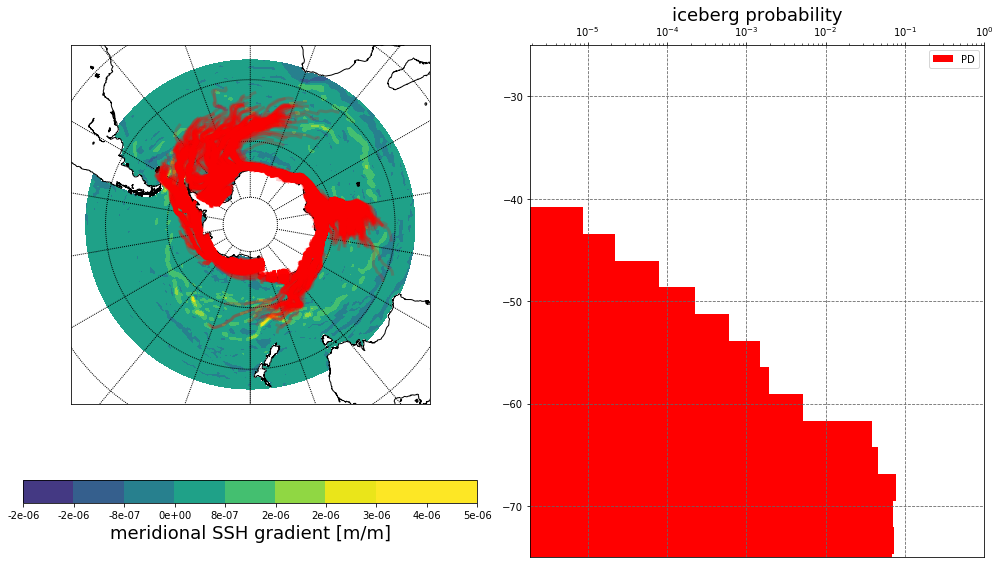

In [97]:
ddy = forcing_vars['sshslope'][2]
XX = forcing_vars['oceanvel'][2]
YY = forcing_vars['oceanvel'][3]
cbar_label="meridional SSH gradient [m/m]"
vmin=-3e-6
vmax=3e-6
#month=0
#plotfield=np.squeeze(ddy[month,:,:])
plotfield=np.squeeze(np.nanmean(ddy[:,:,:], axis=0))
agulhas_positions_PI = plot_SST_probability(EXP, XX, YY, plotfield[0:221], vmin, vmax, potT_PD, lons_df_PD, lats_df_PD, histcolor='r', trackcolor='r')

#### How is the meltwater distributed?

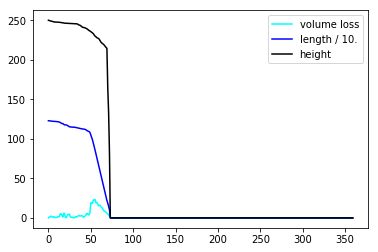

In [98]:
ib=91 #91
howlong=-1 # steps
plt.plot(melt_df[ib].values[0:howlong], color='cyan', label='volume loss')
plt.plot(leng_df[ib].values[0:howlong]/10., color='b', label='length / 10.')
plt.plot(heig_df[ib].values[0:howlong], color='k', label='height')
plt.legend()
plt.show()

In [99]:
melt_df.sum().sum() * delta_t / 1e8, initialvol / 1e8

(16886.01918235329, 54846.235625)

In [100]:
melt_df.sum().sum()

1954400.368327927

#### Now mass is conserved, this works as expected now. Proceed with accumulating the melt water

In [101]:
lons_df.min().min(), lons_df.max().max(), lats_df.min().min(), lats_df.max().max()

(0.0, 359.99209229260777, -77.28343485192333, 0.0)

In [102]:
# aggregate trajectory information into a gridded field
def aggregate(pos_lon, pos_lat, res, outLON, outLAT, weights):
    
    pos_lon=np.copy(pos_lon)
    pos_lat=np.copy(pos_lat)
    
    # set time
    num_records,num_ib=pos_lon.shape
    time=np.tile(np.arange(1,num_records+1,1), (num_ib, 1))
    # define T
    idT=np.floor(time)
    idT=idT.astype('int64')
    
    # find X
    idX=np.floor((pos_lon+180.)*res)+1  # matrix with range [1 ... 360] (or [1 ... 1440])
    idX=idX.astype('int64')
    
    # find Y
    pos_lat[pos_lat>-1.]=southern_lat/res;  # set (0,0) points (iceberg melted) to (0,-80) (land)

    idY=np.floor(abs(pos_lat)*res+northern_lat)+1; # matrix with range [1 ... 43] (or [1 ... 180])
    idY=idY.astype('int64')
    
    # create linear index for accumarray
    # (idX,idY,idT) -> coord (linear index)
    coord = idX.T + (idY.T-1)*outLON + (idT-1)*outLAT*outLON # row-wise 
    coord = np.reshape(coord, (coord.size,1))
    
    #coord.min(), coord.max()
    
    # extend coord to cover the full coord range;
    coord = np.append(coord, outLON*outLAT*num_records-1)
    coord = np.insert(coord, 0, 0)
    #coord.min(), coord.max(), 1, outLON*outLAT*num_records
    
    # Fast solution to MATLAB's accumarray in numpy.
    # https://stackoverflow.com/questions/16856470/is-there-a-matlab-accumarray-equivalent-in-numpy
    # The accumarray accumulates the elements of an array which belong to the same index.
    a = weights # np.ones((coord.size)) # could be meltfield later, now just counting [0, 1, ..., 1, 0]
    a[0]=0
    a[-1]=0
    accmap = coord.flatten() # linear index of all (X,Y,T)

    # do the counting
    result=np.bincount(accmap, weights=a)
    
    # reshape to (T,Y,X)
    result_reshape=np.reshape(result, (num_records, outLAT, outLON))
    result_reshape[:,outLAT-1,:]=0. # set land values to zero
    
    return result_reshape

In [103]:
# gridded melt field at which resolution?
res=1 #1: 1 deg x 1 deg regular mesh

western_lon=-180.0*res
#eastern_lon=abs(western_lon)-1
eastern_lon=180.0
xgv=np.arange(western_lon, eastern_lon+1, 1) #western_lon:1:eastern_lon
northern_lat=-20.0*res 
southern_lat=-80.0*res
ygv=np.arange(northern_lat, southern_lat-1, -1) #northern_lat:-1:southern_lat
        
[X,Y] = np.meshgrid(xgv,ygv)

outLON=xgv.size
outLAT=ygv.size

In [104]:
def plot_spatial_meltwater_dist(EXP, lons_df, lats_df, melt_df, cmap=cm.Reds, BYUcolor='k', range=[0,50], histcolor='r'):
    
    # set the weights
    weightsNUM=np.ones((lons_df.size+2)) # iceberg counts
    print('Sum of all count weights is ' + str(weightsNUM.sum()) + ', size + 2: ' + str(melt_df.size + 2))

    weights=np.copy(melt_df.values.T.flatten()) # iceberg volume loss
    weights = np.append(weights, 0.)
    weights = np.insert(weights, 0, 0.)
    print('Sum of all vol weights is ' + str(weights.sum() * delta_t) + ', init. vol: ' + str(initialvol))

    # grid the trajectories into 1x1 degree field
    result=aggregate(lons_df, lats_df, res, outLON, outLAT, weights)
    
    # create figure
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
    
    # set mercator projection
    #m = Basemap(llcrnrlon=-70.,llcrnrlat=-75.,urcrnrlon=100.,urcrnrlat=-25.,\
                #resolution='l',projection='merc',\
                #lat_0=-60.,lon_0=0.,lat_ts=None, ax=ax[0])

    #m.drawcoastlines()
    #m.fillcontinents(color='0.1',lake_color='lightblue')

    # draw parallels and meridians.
    #m.drawparallels(np.arange(-80.,81.,20.))
    #m.drawmeridians(np.arange(-180.,181.,20.))
    #m.drawmapboundary(fill_color='lightblue')

    # remap the coordinates
    #lon_map,lat_map=m(X,Y)
    m = Basemap(projection='spstere',boundinglat=-30,lon_0=180,resolution='l', ax=ax[0]) # -180..180

    m.drawcoastlines()
    #m.fillcontinents(color='0.1',lake_color='lightblue')

    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    #m.drawmapboundary(fill_color='lightblue')

    lon_map, lat_map = m(X,Y)
    
    # plot melt water field [convert vol/timestep -> vol -> mass -> tonnes -> gigatonnes]
    cbar_label=EXP+" iceberg melt water [Gt]"
    plotfield=np.nansum(result[:,:,:], axis=0) * delta_t * rho_icb / 1000. / 1.e9 # Gt
    plotfield=np.ma.masked_array(plotfield, mask=plotfield==0.)

    # plot the field
    im=m.pcolormesh(lon_map,lat_map,plotfield, norm=colors.LogNorm(vmin=1.e-2, vmax=1.), cmap=cmap, ax=ax[0])

    # plot APcomp
    #y_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
    #x_APcomp=20.5
    #xAPcomp_map,yAPcomp_map=m(x_APcomp,y_APcomp)
    #ax[0].plot(xAPcomp_map, yAPcomp_map, 'k*', markersize=20)

    cbar=plt.colorbar(im, orientation='horizontal', ax=ax[0])
    #cbar=plt.colorbar(im, orientation='horizontal', format='%.0e', ax=ax)
    cbar.set_label(cbar_label, fontsize=18)
    ax[0].legend()

    #####################
    SECTOR=np.logical_and(X>-180, X<180)
    computeDIST=np.zeros(plotfield.shape)
    computeDIST[SECTOR]=plotfield[SECTOR]
    LATS=Y[:,0]
    plt.rc('grid', linestyle="--", color='0.4')
    ax[1].grid(True)
    ax[1].barh(LATS, np.sum(computeDIST,axis=1), color=histcolor, label=EXP, align='center', alpha=0.5)
    ax[1].set_ylim((-80,-35))
    ax[1].set_xlim((0.,100.))
    ax[1].xaxis.tick_top()
    ax[1].xaxis.set_label_position('top') 
    ax[1].set_xlabel('meltwater distribution [Gt]', fontsize=18)  
    ax[1].set_ylabel('latitude', fontsize=18)  
    ax[1].text(1.1,-57,EXP+' total: '+str(np.round(computeDIST.sum().sum(),2))+' Gt', color=histcolor)
    plt.legend()

    plt.hlines(-40, 0., 4.)

    plt.show()
    
    return LATS, computeDIST

Sum of all count weights is 2761291.0, size + 2: 2761291
Sum of all vol weights is 1688601918235.3293, init. vol: 5484623562500.0


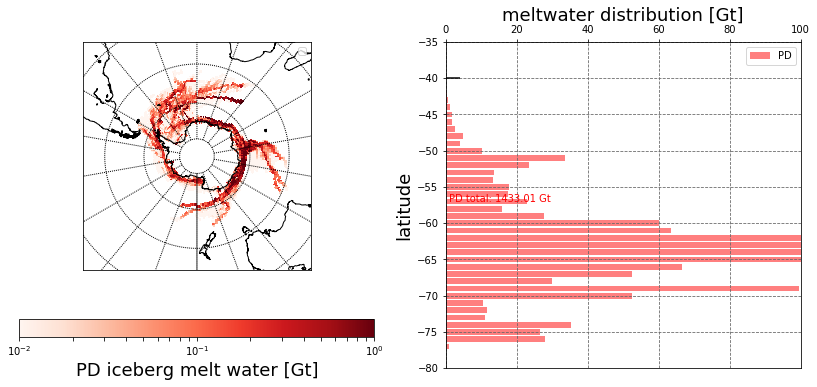

In [105]:
# plot the meltwater field and its meridional distribution in 'range' (e.g. 0-50E)
LATS, computeDIST_PI = plot_spatial_meltwater_dist(EXP, lons_df_PD, lats_df_PD, melt_df_PD, cmap=cm.Reds, BYUcolor='tab:purple', range=[0,50])